# The Simpsons Classifier CNN Project

In this project I used the simpsons dataset (https://www.kaggle.com/alexattia/the-simpsons-characters-dataset) to create a Simpsons identifier using convolutional neural networks.

I chose this dataset as it is challenging given the nature of the images, every character is presented in a variety of situations with different backgrounds, different angles, different facial expressions and sometimes even different outfits.

#### Importing libraries


In [ ]:
# For deeplearning
import tensorflow as tf       
from tensorflow import keras 
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.preprocessing.image import ImageDataGenerator      
# Vectorized code, translate images into vector arrays
import numpy as np            
# For data visualization
import matplotlib.pyplot as plt  
# For managing files         
import os            
# Translates images into numbers
from PIL import Image             
# Data processing, confusion matrix and classification report
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
# Utilities
import copy 
import itertools         

## 1. Loading data

In [ ]:
path_train = '/content/drive/MyDrive/Deep Learning Datasets/simpsons/simpsons_dataset'
path_test = '/content/drive/MyDrive/Deep Learning Datasets/simpsons/kaggle_simpson_testset/kaggle_simpson_testset'

In [ ]:
classes = len(os.listdir(path_train)) # How many classes are there?
characters = sorted(os.listdir(path_train)) # List of characters
print(classes) 

20


### 1.1 Loading training set

My first idea was to upload the images with a size of 224x224 as the VGG16 was trained using that size, after crashing the memory several times I decided to use half of the size (112x112)

In [ ]:
image_size = (112,112)
data = []
labels = []

for i in characters:     # Iterating through all directories in the training set
    path = path_train + '/' + i
    images = sorted(os.listdir(path))

    for file in images:    # Iterating through all the images in each directory
        try:
            image = Image.open(path + '/' + file)
            image = image.resize(image_size)   
            image = np.array(image)
            data.append(image)
            labels.append(i)        # Every directory has the name of its label
        except:
            print(f'Error loading image, character: {i}, file: {file}')

data = np.array(data)
labels = np.array(labels)

In [ ]:
# Saving the numpy arrays in case we need to re run the code
# np.save('/content/drive/MyDrive/Deep Learning Datasets/training_set_simpsons_112.npy', data)
# np.save('/content/drive/MyDrive/Deep Learning Datasets/labels_simpsons_112.npy', labels)

In [ ]:
data = np.load('/content/drive/MyDrive/Deep Learning Datasets/training_set_simpsons_112.npy')
labels = np.load('/content/drive/MyDrive/Deep Learning Datasets/labels_simpsons_112.npy')

In [ ]:
# Checking data shape is as it should
print(data.shape)
print(labels.shape)

(19581, 112, 112, 3)
(19581,)


#### 1.1.1 Splitting the training set into training and validation sets

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(data, labels, 
                                                                test_size=0.3, 
                                                                random_state=42)

In [ ]:
del data # We don't need it anymore, we remove it to save RAM

In [ ]:
# Checking that the shape of the data is correct

print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(13706, 112, 112, 3)
(5875, 112, 112, 3)
(13706,)
(5875,)


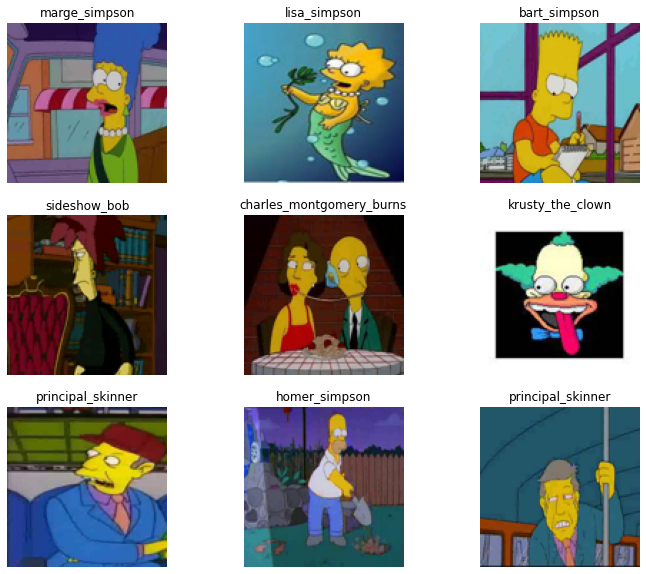

In [ ]:
# Checking the images were loaded correctly

fig = plt.figure(figsize=(12, 10))
columns = 3
rows = 3
for i in range(1, columns*rows + 1):
    img = X_train[i,:,:,:]
    lb = y_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

### 1.2 Loading test set

In [ ]:
test_data = []
test_labels = []

for i in sorted(os.listdir(path_test)):
    path = path_test + '/' + i
    image = Image.open(path)
    image = image.resize(image_size)
    image = np.array(image)
    test_data.append(image)
    split_label = i.split('_') 
    label = '_'.join(split_label[:-1]) # First elements are characters' names 
    test_labels.append(label) 

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
# np.save('/content/drive/MyDrive/Deep Learning Datasets/X_test_simpsons_112.npy', test_data)
# np.save('/content/drive/MyDrive/Deep Learning Datasets/y_test_simpsons_112.npy', test_labels)

In [ ]:
X_test = np.load('/content/drive/MyDrive/Deep Learning Datasets/X_test_simpsons_112.npy')
y_test = np.load('/content/drive/MyDrive/Deep Learning Datasets/y_test_simpsons_112.npy')

In [ ]:
# Once we load the X_test and y_test we remove the test_data and test_labels to save RAM
del test_data
del test_labels

In [ ]:
print(X_test.shape)
print(y_test.shape)

(990, 112, 112, 3)
(990,)


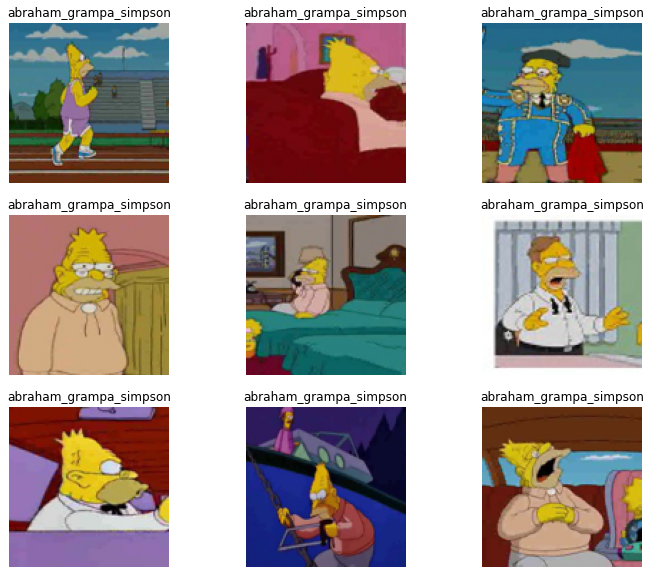

In [ ]:
# Visualizing some test set images

fig = plt.figure(figsize=(12, 10))
columns = 3
rows = 3
for i in range(1, columns*rows + 1):
    img = X_test[i,:,:,:]
    lb = y_test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

## 2. Data processing

### 2.1 Processing labels

The model will only accept numbers or one hot encoded arrays, for that reason it's esential to one hot encode the labels, as converting the categories in number it establishes a certain order between them and that's not what I am looking for.

For that purpose it's necessary to first convert them into integers using the scikit learn function *label_encoder* and then to one hot encode these integers using the tensorflow utils function *to_categorical*.

In [ ]:
# Getting unique values for every class
class_names  = sorted(list(set(characters)))
class_names # These are the 20 different characters we are trying to identify

['abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'comic_book_guy',
 'edna_krabappel',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lisa_simpson',
 'marge_simpson',
 'mayor_quimby',
 'milhouse_van_houten',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'principal_skinner',
 'sideshow_bob']

In [ ]:
def to_onehot_categorical(y, class_names):
    '''This function accepts the categories from the output (y), and the name
    of the categories (class_names), and returns the output in on hot
    encoding'''

    label_encoder = LabelEncoder() 
    vec_y = label_encoder.fit_transform(y)      # encoding classes into integers
    return to_categorical(vec_y, num_classes=len(class_names))    # into one hot

In [ ]:
y_train_hot = to_onehot_categorical(y_train, class_names)
y_validation_hot = to_onehot_categorical(y_validation, class_names)
y_test_hot = to_onehot_categorical(y_test, class_names)

### 2.2 Data normalization



In [ ]:
# We convert to np.float32 as it less heavy and still compatible with tensorflow
X_train = (X_train/255).astype(np.float32)
X_validation = (X_validation/255).astype(np.float32)
X_test = (X_test/255).astype(np.float32)

## 3. Modeling

### 3.1 CNN Model

After trying several architectures I decided to use this convolutional neural network architecture. It's inspired by the CNN early models like LeNet-5 and AlexNet, basically a **simple CNN that alternates convolutional layers with max pooling layers**, and uses **ReLU as the activation dunction**.

The number of filters increases steadily by two with every layer as the images size gets reduced by 2 with every maxpool layer.

Adding **two adjacent convolutional layers (like in AlexNet) didn't translate into a better performance**, so I decided to keep them separated with maxpool layers.

It ends with **three dense layers, with a dropout regularization of 50% applied to the first dense layer**, interestingly enough, this has proved to be better than adding 20% dropout regularization to two of the dense layers which had proved me to be the best in other cases, but not in this particular one. It ends in a **softmax function** as I'm trying to solve a classification problem. 

Adding batch normalization didn't made any improvement, it softened the overfitting but it brought down the accuracy in all sets, so I decided **not to use batch normalization**.

The optimizer **adam** was the one that performed the better for this problem, so it was selected, the second best was **RMSprop**.

The model has 697,972 trainable parameters.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation='relu', padding='valid', 
                        input_shape=X_train[0].shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 108, 108, 16)      1216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 128)      

In [ ]:
# Adding early stopping if the accuracy doesn't increase in 5 epochs
earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 monitor='val_accuracy', 
                                                 mode='max')

# A batch size of 64 seemed to be the optimal after several trials
h = model.fit(X_train, y_train_hot, 
              validation_data=(X_validation, y_validation_hot), epochs=10, 
              batch_size=64, callbacks=[earlystopping])


Epoch 1/10
215/215 [==============================] - 21s 23ms/step - loss: 2.7559 - accuracy: 0.1429 - val_loss: 2.3852 - val_accuracy: 0.2526
Epoch 2/10
215/215 [==============================] - 4s 19ms/step - loss: 2.1901 - accuracy: 0.3245 - val_loss: 1.8229 - val_accuracy: 0.4563
Epoch 3/10
215/215 [==============================] - 4s 19ms/step - loss: 1.6705 - accuracy: 0.4853 - val_loss: 1.2942 - val_accuracy: 0.6187
Epoch 4/10
215/215 [==============================] - 4s 19ms/step - loss: 1.2322 - accuracy: 0.6209 - val_loss: 0.9247 - val_accuracy: 0.7183
Epoch 5/10
215/215 [==============================] - 4s 19ms/step - loss: 0.9525 - accuracy: 0.7086 - val_loss: 0.8562 - val_accuracy: 0.7351
Epoch 6/10
215/215 [==============================] - 4s 19ms/step - loss: 0.7422 - accuracy: 0.7697 - val_loss: 0.7559 - val_accuracy: 0.7797
Epoch 7/10
215/215 [==============================] - 4s 19ms/step - loss: 0.6015 - accuracy: 0.8208 - val_loss: 0.6577 - val_accuracy: 0.815

#### 3.1.1 CNN model performance

Training set accuracy: 94.67%  <br>
Validation set accuracy: 84.87%  <br>
Test set accuracy: 91.31% 


These are good accuracy scores, but the difference between the training set and the validation set is of almost 10 percentage points, which means **there is overfitting** and the model might not generalize well (even though it performed very well in the test set). Reducing the overfitting is necessary.

In [ ]:
model.evaluate(X_train, y_train_hot)

429/429 [==============================] - 2s 5ms/step - loss: 0.1754 - accuracy: 0.9467


[0.1754368543624878, 0.9467386603355408]

In [ ]:
model.evaluate(X_validation, y_validation_hot)

184/184 [==============================] - 1s 6ms/step - loss: 0.6229 - accuracy: 0.8487


[0.6228957176208496, 0.848680853843689]

In [ ]:
model.evaluate(X_test, y_test_hot)

31/31 [==============================] - 0s 11ms/step - loss: 0.3216 - accuracy: 0.9131


[0.3216087222099304, 0.9131312966346741]

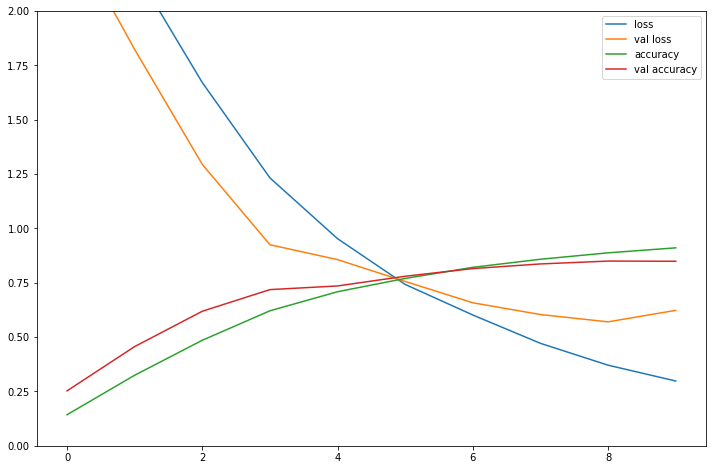

In [ ]:
# Plotting the behaviour of the training and validation sets
plt.figure(figsize=(12,8))
plt.plot(h.history['loss'], label = 'loss')
plt.plot(h.history['val_loss'], label = 'val loss')
plt.plot(h.history['accuracy'], label = 'accuracy')
plt.plot(h.history['val_accuracy'], label = 'val accuracy')
plt.gca().set_ylim(0,2)
plt.legend()

#### 3.1.2 CNN model with data aumegntation

As the first model was overfitting to the training set, I decided to **use data augmentation**, this way it will be possible to feed the model with transformed versions of the images of the training set, eventually making the model to perform better and reduce overfitting.

The images will be rotated, width shifted, height shifted, sheared, horizontally flipped and zoomed.

In [ ]:
batch_size = 32

data_generator = ImageDataGenerator(rotation_range=35, width_shift_range=0.2, 
                                    height_shift_range=0.15, shear_range=0.2, 
                                    horizontal_flip=True, zoom_range=0.4, 
                                    fill_mode="nearest")

train_generator = data_generator.flow(X_train, y_train_hot, batch_size=batch_size)

steps_per_epoch = X_train.shape[0] // batch_size

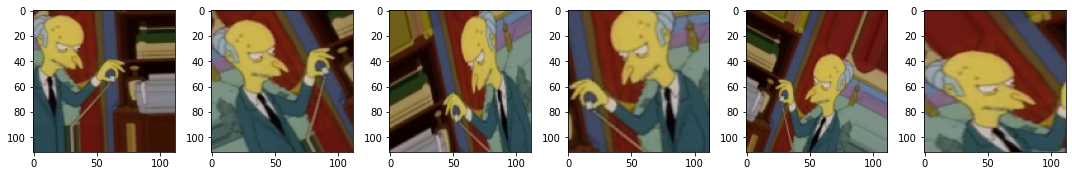

In [ ]:
# Let's check how the data augmentation transformed the pictures with an example
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
          validation_data=(X_validation, y_validation_hot))

Epoch 1/10
428/428 [==============================] - 37s 84ms/step - loss: 1.2511 - accuracy: 0.6438 - val_loss: 0.6923 - val_accuracy: 0.8100
Epoch 2/10
428/428 [==============================] - 36s 83ms/step - loss: 1.0420 - accuracy: 0.7016 - val_loss: 0.5711 - val_accuracy: 0.8468
Epoch 3/10
428/428 [==============================] - 36s 83ms/step - loss: 0.9693 - accuracy: 0.7241 - val_loss: 0.4854 - val_accuracy: 0.8722
Epoch 4/10
428/428 [==============================] - 36s 83ms/step - loss: 0.8941 - accuracy: 0.7498 - val_loss: 0.5437 - val_accuracy: 0.8454
Epoch 5/10
428/428 [==============================] - 35s 82ms/step - loss: 0.8422 - accuracy: 0.7637 - val_loss: 0.4434 - val_accuracy: 0.8800
Epoch 6/10
428/428 [==============================] - 35s 83ms/step - loss: 0.7650 - accuracy: 0.7859 - val_loss: 0.4436 - val_accuracy: 0.8778
Epoch 7/10
428/428 [==============================] - 35s 82ms/step - loss: 0.7765 - accuracy: 0.7861 - val_loss: 0.4197 - val_accuracy:

#### 3.1.3 CNN model with data augmentation performance

Training set accuracy: 91.32%  <br>
Validation set accuracy: 89.11%  <br>
Test set accuracy: 89.29% 

Even if the test set accuracy decreased by 2% this is still better, as this **model is almost not overfitting the training set** (there is just a 2% difference between the precision in the validation/test sets and the precision in the training set), thus it also performed way better in the validation set (89.11% compared to the 84.87% previously achieved). This model can be generalized.

In [ ]:
model.evaluate(X_train, y_train_hot)

429/429 [==============================] - 2s 5ms/step - loss: 0.2922 - accuracy: 0.9132


[0.29222163558006287, 0.913249671459198]

In [ ]:
model.evaluate(X_validation, y_validation_hot)

184/184 [==============================] - 1s 5ms/step - loss: 0.4157 - accuracy: 0.8911


[0.41568005084991455, 0.8910638093948364]

In [ ]:
model.evaluate(X_test, y_test_hot)

31/31 [==============================] - 0s 6ms/step - loss: 0.4017 - accuracy: 0.8929


[0.40165072679519653, 0.8929293155670166]

#### 3.1.4 Analizing model predictions

The model accuracy on the test set is 89.29%, the Keras *model.predict* function returns us an array where each of the indexes is a character, and the number given is the probability of being that character from 0 to 1. It is necessary to codify the index with the biggest number as the name of the character.

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
def label_translator(class_names, y_pred):
    '''This function accepts a list with the original name of the classes 
    (class_names) and the predicted results (y_pred), returning 
    a list of the predicted results translated into the original class names'''

    y_copy = copy.deepcopy(y_pred)

    # Creating one hot encoded arrays out of the probability results output
    masked = []
    for prediction in y_copy:
        # Making the greatest probability 1 and the rest 0 with a mask
        prediction[np.argmax(prediction)] = 1
        masked.append((prediction >= 1).astype('int32'))

    # One hot encoding the characters array for reverse translation
    class_names_hot = to_onehot_categorical(class_names, class_names)

    # Transforming each one hot encoded output into a string to be used as a key
    stringed_hot = [str(onehot.astype('int32')) for onehot in class_names_hot]
    labels_dict = dict(zip(stringed_hot, class_names))
     
    return [labels_dict[str(array)] for array in masked]

In [ ]:
# Confusion matrix comparing the predictions and the actual test labels
y_test_predicted = label_translator(class_names, y_pred)
confusion_matrix = confusion_matrix(y_test, y_test_predicted)

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    '''This function prints and plots the confusion matrix.'''

    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

As we can see, in the plotted confusion matrix below, the characters that the model confuses the most are Homer and his father (Abraham 'Grampa' Simpson), which one could argue it makes sense.

The second most confused characters are the Comic Book Guy and Director Skinner, which to be honest, I don't find them to look alike at all.

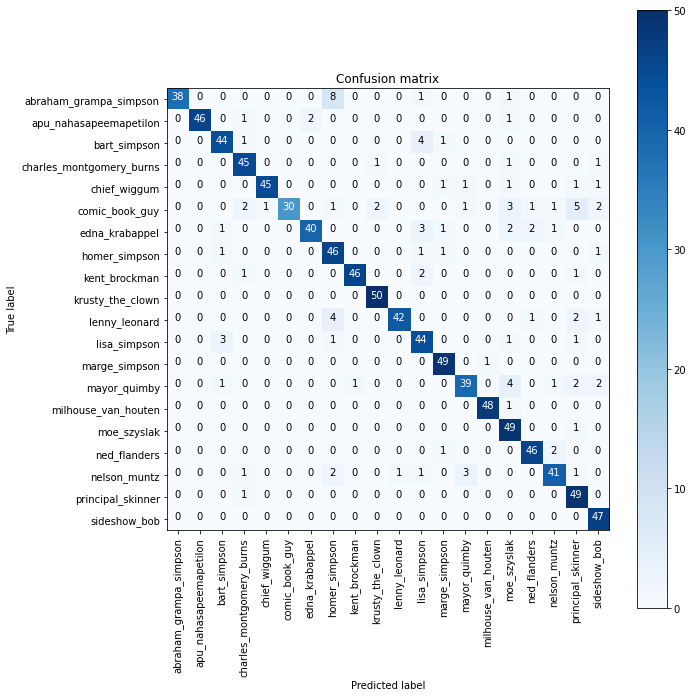

In [ ]:
plot_confusion_matrix(cm = confusion_matrix, classes = class_names)

In the classification report we can see that there is a 100% **precision** when it comes to the characters Abraham 'Grampa' Simpson, Apu Nahasapeemapetilon and the Comic Book Guy, This means that the model predicted these characters the 100% of the times. The character that was predicted with the least precision was Homer Simpson, he was correctly predicted 74% of the times.

When it comes to **recall**, the two characters that showed a better result were Krusty the Clown and Sideshow Bob, which makes sense as they are two of the most distinguishable characters on the show. This means that the model didn't confuse any of the other characters with these two. On the other hand, Comic Book Guy was the character with the least recall (61%) meaning that the model often predicted other characters as him.

The **F1 score** takes into account both, precision and recall, so we can see that the better predicted characters where the ones with the highest F1 score (least type I and type II error), in this case it will be Krusty the Clown with a F1 score of 97%. The character with the least F1 score was Comic Book Guy, which scored a 100% in precision but the recall score brought down his F1 score down.



In [ ]:
print(classification_report(y_test, y_test_predicted))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.79      0.88        48
  apu_nahasapeemapetilon       1.00      0.92      0.96        50
            bart_simpson       0.88      0.88      0.88        50
charles_montgomery_burns       0.87      0.94      0.90        48
            chief_wiggum       0.98      0.90      0.94        50
          comic_book_guy       1.00      0.61      0.76        49
          edna_krabappel       0.95      0.80      0.87        50
           homer_simpson       0.74      0.92      0.82        50
           kent_brockman       0.98      0.92      0.95        50
        krusty_the_clown       0.94      1.00      0.97        50
           lenny_leonard       0.98      0.84      0.90        50
            lisa_simpson       0.79      0.88      0.83        50
           marge_simpson       0.91      0.98      0.94        50
            mayor_quimby       0.89      0.78      0.83        50
     milh

In [ ]:
# model.save('/content/drive/MyDrive/Deep Learning Datasets/model.h5')
model = keras.models.load_model('/content/drive/MyDrive/Deep Learning Datasets/model.h5')

### 3.2 Transfer learning model (VGG16):

The VGG16 is an already trained convolutional neural network that was used for the ImageNet contest, it was designed, therefore, to classify real images of many different objects.  I decided to try and use it for this project to see if it could outperform my own model.

The VGG16 consists of 16 layers, 13 of them convolutional ones that are adjacents to each other in groups of 3 in the first two groups and in groups of 2 in the last two convolutional groups,separating these groups there are maxpooling layers, it then ends in 3 dense layers. 

Here is a diagram for a clearer view:


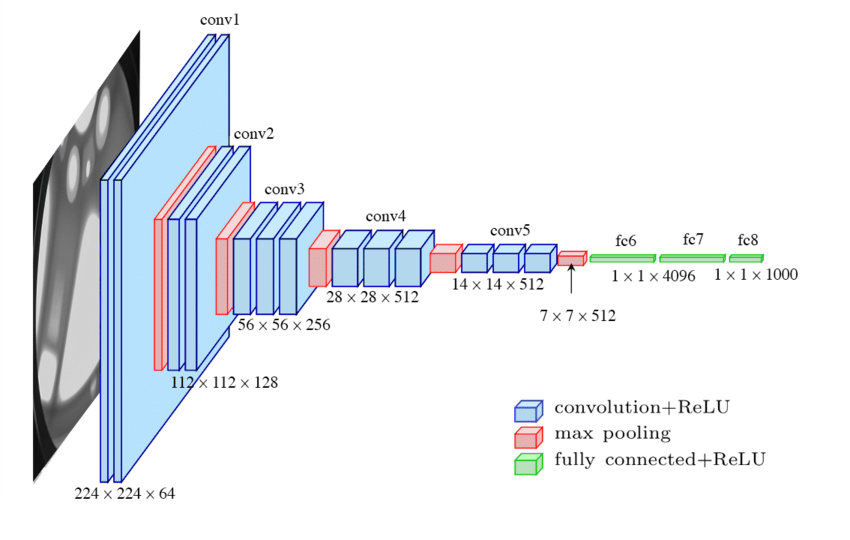

It was trained to be used with 224x224 images, unfortunately, my memory cannot take it so I had to reduce that size by half (112x112).

In [ ]:
# We import the model using keras
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=[112,112,3],
    weights='imagenet',
    include_top=False)

In [ ]:
# Freezing pretrained model convolutional layers weights
vgg16.trainable = False

In [ ]:
# Creating our own top part, these dense layers will be trained 

top_part = keras.layers.Flatten()(vgg16.output)
top_part = keras.layers.Dense(128, activation='relu')(top_part)
top_part = keras.layers.Dropout(0.5)(top_part)
top_part = keras.layers.Dense(64, activation='relu')(top_part)
top_part = keras.layers.Dense(classes, activation='softmax')(top_part)

In [ ]:
# We put together both parts like this

model_vgg16 = tf.keras.models.Model(inputs=vgg16.input, outputs=top_part)

In [ ]:
# Like this, only 599,508 out of 15,314,196 parameters will be trainable

model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0   

In [ ]:
model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
r_vgg16 = model_vgg16.fit(X_train, y_train_hot, steps_per_epoch=steps_per_epoch, epochs=15, 
                        validation_data=(X_validation, y_validation_hot), callbacks=[earlystopping])

#### 3.2.1 VGG16 transfer learning model performance

Training set accuracy: 91.17%  <br>
Validation set accuracy: 73.24%  <br>
Test set accuracy: 80.91% 

The **VGG16 transfer learning model performed way worse than the previous model**, the accuracy is poorer in all sets and it is clearly overfitted, the difference between the training set accuracy and the validation set accuracy is of almost 18 percentage points. 

It performed better in the test set but still not anywhere near the performance of the previous model.

In [ ]:
model_vgg16.evaluate(X_train, y_train_hot)

429/429 [==============================] - 17s 39ms/step - loss: 0.3536 - accuracy: 0.9117


[0.35355761647224426, 0.9117174744606018]

In [ ]:
model_vgg16.evaluate(X_validation, y_validation_hot)

184/184 [==============================] - 7s 37ms/step - loss: 0.9971 - accuracy: 0.7324


[0.9970747232437134, 0.7324255108833313]

In [ ]:
model_vgg16.evaluate(X_test, y_test_hot)

31/31 [==============================] - 3s 91ms/step - loss: 0.6701 - accuracy: 0.8091


[0.6701236367225647, 0.8090909123420715]

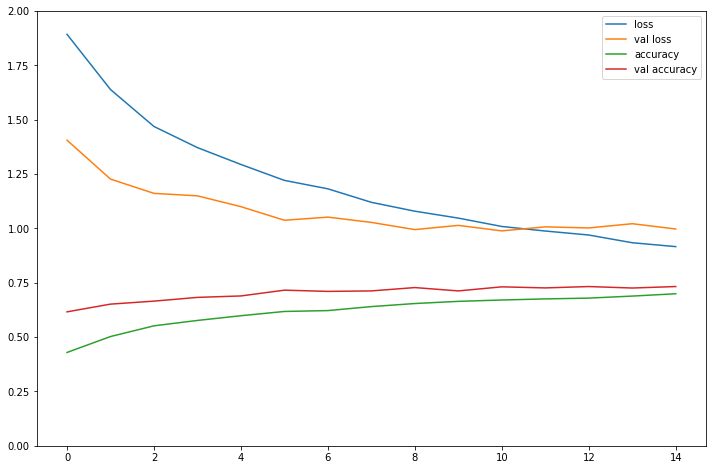

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r_vgg16.history['loss'], label = 'loss')
plt.plot(r_vgg16.history['val_loss'], label = 'val loss')
plt.plot(r_vgg16.history['accuracy'], label = 'accuracy')
plt.plot(r_vgg16.history['val_accuracy'], label = 'val accuracy')
plt.gca().set_ylim(0,2)
plt.legend()

In [ ]:
# Saving model for future use
# model_vgg16.save('/content/drive/MyDrive/Deep Learning Datasets/model_vgg16.h5')
model_vgg16 = keras.models.load_model('/content/drive/MyDrive/Deep Learning Datasets/model_vgg16.h5')

## 4. Predicting external data

To test the model to a greater extent I tried it using my own drawing, a frame from the series and series of photo-realistic depiction of the characters.

For processing these external images I had to define several functions:

In [ ]:
  def process_drawing(path, image_size=(112,112)):
    '''This function accepts an image as a path and process it to make it fit 
    for feeding it to the model, it also allows setting the size. It returns
    the image as a numpy array '''

    image = Image.open(path)
    image = image.resize(image_size)
    image = np.array(image)
    image = (image/255).astype(np.float32)

    return np.array([image])

In [ ]:
def drawing_probabilities(path, model=model):
    '''This function accepts an image as a path and a model, it displays the 
    probabilities of it of belonging to a certaing character.
    It returns a printed report of the characters and the probabilities'''

    drawing = process_drawing(path)
    prediction = model.predict(drawing)
    predicted_character = label_translator(class_names, prediction)

    # Dictionary with class names as keys and probabilities as values
    probs_dict = {value:prediction[0][i] for i, value in enumerate(class_names)}

    print('CHARACTER\t\t    PROBABILITY')
    for i in class_names: print(f'{i:<30} {probs_dict[i]*100:.2f}%')

In [ ]:
def drawing_results(path, model=model):
    '''This function accepts an image as a path and a model, it displays the
    picture of the image, the name of the predicted character, and the 
    probability of being that character according to the model'''

    drawing = process_drawing(path)
    prediction = model.predict(drawing)
    predicted_character = label_translator(class_names, prediction)

    probs_dict = {value:prediction[0][i] for i, value in enumerate(class_names)}

    plt.title(f'''CHARACTER: {predicted_character[0]}
    PROBABILITY: {probs_dict[predicted_character[0]]*100:.2f}%''')
    plt.imshow(drawing[0])

### 4.1 Predicting my drawing

I drew Homer Simpson and got Montgomery Burns with a probability of 77.87% instead.

We have to remember that the model was trained to see characters straight out of the show frames. My drawing, for example, has a blank background that could have caused the confusion... aside from my not so good drawing skills, of course.

It's also interesting to note that the probabilities of being homer were just of 0.15% according to the model.

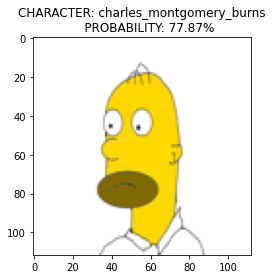

In [ ]:
path_drawing = '/content/drive/MyDrive/Images/homer.jpg'
drawing_results(path_drawing)

In [ ]:
drawing_probabilities(path_drawing)

CHARACTER		    PROBABILITY
abraham_grampa_simpson         0.09%
apu_nahasapeemapetilon         0.00%
bart_simpson                   2.86%
charles_montgomery_burns       77.87%
chief_wiggum                   0.36%
comic_book_guy                 0.20%
edna_krabappel                 0.11%
homer_simpson                  0.15%
kent_brockman                  0.14%
krusty_the_clown               0.05%
lenny_leonard                  0.00%
lisa_simpson                   10.34%
marge_simpson                  0.03%
mayor_quimby                   0.45%
milhouse_van_houten            0.48%
moe_szyslak                    6.33%
ned_flanders                   0.01%
nelson_muntz                   0.08%
principal_skinner              0.34%
sideshow_bob                   0.11%


### 4.2 Predicting a show frame not present in the dataset.

At the end, I trained the model to predict The Simpsons characters from the show, so I tried with a challenging example, like that time Homer saw bart as a rat person.

The model performed great as it classified Bart with a probability of 94.63%, this is what the model was trained for. 

The second character most probable of being depicted in the image was Lisa Simpson, which is Bart's sister.

In [ ]:
path_rat_boy = '/content/drive/MyDrive/Images/257873.jpg'

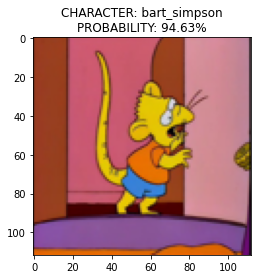

In [ ]:
drawing_results(path_rat_boy)

In [ ]:
drawing_probabilities(path_rat_boy)

CHARACTER		    PROBABILITY
abraham_grampa_simpson         0.00%
apu_nahasapeemapetilon         0.00%
bart_simpson                   94.63%
charles_montgomery_burns       0.09%
chief_wiggum                   0.01%
comic_book_guy                 0.02%
edna_krabappel                 0.03%
homer_simpson                  0.06%
kent_brockman                  0.00%
krusty_the_clown               0.01%
lenny_leonard                  0.00%
lisa_simpson                   4.23%
marge_simpson                  0.01%
mayor_quimby                   0.01%
milhouse_van_houten            0.01%
moe_szyslak                    0.02%
ned_flanders                   0.03%
nelson_muntz                   0.78%
principal_skinner              0.02%
sideshow_bob                   0.02%


### 4.3 Comparing both models

Doing different experiments I realized that the VGG16 model was performing better with photo-realistic depictions of The Simpsons characters, which might have to do with the fact that the VGG16 convolutional layers were trained using real images.

I will show now different examples.

In [ ]:
def model_comparator(path, model1 = model, model2 = model_vgg16):
    '''The model accepts an image and two models, it returns two pictures of the 
    same character with the model used as a title plus the predicted character
    and their probabilities'''

    drawing = process_drawing(path)

    prediction1 = model1.predict(drawing)
    predicted_character1 = label_translator(class_names, prediction1)
    probs_dict1 = {value:prediction1[0][i] for i, value 
                   in enumerate(class_names)}

    prediction2 = model2.predict(drawing)
    predicted_character2 = label_translator(class_names, prediction2)
    probs_dict2 = {value:prediction2[0][i] for i, value 
                   in enumerate(class_names)}
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

    axes[1].imshow(drawing[0])
    axes[1].set_title(f'''LeNet-5/AlexNet Inspired Model
    CHARACTER: {predicted_character1[0]}
    PROBABILITY: {probs_dict1[predicted_character1[0]]*100:.2f}%''')

    axes[0].imshow(drawing[0])
    axes[0].set_title(f'''VGG16 Transfer Learning Model
    CHARACTER: {predicted_character2[0]} 
    PROBABILITY: {probs_dict2[predicted_character2[0]]*100:.2f}%''')

    for a in axes:
        a.axis('off')

    plt.tight_layout()

In [ ]:
path_photo = '/content/drive/MyDrive/Images/e19713f503dbb7a340fb26e91d146972.jpg'
burns = '/content/drive/MyDrive/Images/burns.jpg'
moe = '/content/drive/MyDrive/Images/moe.jpg'

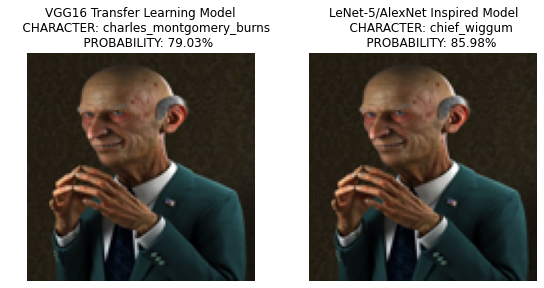

In [ ]:
model_comparator(path_photo)

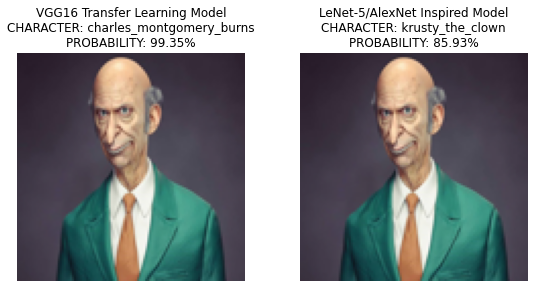

In [ ]:
model_comparator(burns)

Although it's not always the case, as we can see with the case of Moe Szyslak below:

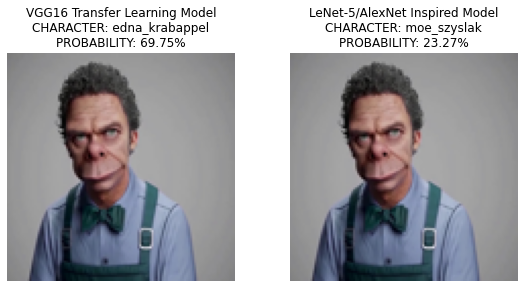

In [ ]:
model_comparator(moe)

## What I've learned during this project:
  * **Thoroughly checking the dataset beforehand is essential**, this dataset had more classes in the train set than in the test set given, after a second examination I also realized there were very few examples in each of these extra classes. I finally decided to remove those extra classes.
  * **Paying attention to the memory you are using**, specially when you are dealing with heavy datasets like this one, I've learned how not to use unnecesary amounts of RAM declaring unnecessary new variables or copies and deleting variables that I wasn't going to use anymore. Also, converting to integer32 or integer16 and float32 or float16 makes it lighter and therefore faster.
  * Using shallow copies when necessary **using nested numpy arrays** is not advisable, **better to use deep copies** or else you might have encounter problems afterwards.
  * There is a tradeof between speed and accuracy when choosing the batch size, but **there is a point where reducing the batch size do not translates into more accuracy** and it can even reverse the tendency.
  * **Adding batch normalization doesn't always improve results**, specially when your neural network is not that deep (the deepest I tried was a 15 layers deep CNN). Also, where you put batch normalization is important, I've realized that it has a **bigger and sometimes detrimental effect if batch normalization is added right before the dense layers**. Inserting batch normalization **after the first max pool layers gave better results**, at least in this project. At the end I decided it was better not to use any batch normalization.
  * It is **better to save heavy numpy arrays and models** in your hard disk or cloud, so you can use them later not needing to run everything again.
  * Even **if one of your models performs worse than others it can be useful for a different type of pictures**, in this project my customized VGG16 performed worse than other models, but it proved to be better for classifying photo-realistic pictures of the characters.
  * **Using transfer learning**, and customizing an already existing model. 
  * **Using data augmentation**.
  * For this particular project, **using a simple architecture** of 5 layers of convolutional layer + max pooling, thus 3 dense layers at the end, **yielded better results** than more complex convolutional neural networks I tried.